In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
np.random.seed(42)
tf.random.set_seed(42)
import os

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

data_path = 'C:/Users/temmy/Downloads/CPE_ML/stanford-rna-3d-folding'

print("Files in folder:")
print(os.listdir(data_path))



Files in folder:
['MSA', 'sample_submission.csv', 'test_sequences.csv', 'train_labels.csv', 'train_sequences.csv', 'validation_labels.csv', 'validation_sequences.csv']


In [9]:
# Load training data
train_seq = pd.read_csv(f'{data_path}/train_sequences.csv')
train_labels = pd.read_csv(f'{data_path}/train_labels.csv')

# Load validation data
val_seq = pd.read_csv(f'{data_path}/validation_sequences.csv')
val_labels = pd.read_csv(f'{data_path}/validation_labels.csv')

# Load test data
test_seq = pd.read_csv(f'{data_path}/test_sequences.csv')



In [10]:
print(train_seq.head())

  target_id                            sequence temporal_cutoff  \
0    1SCL_A       GGGUGCUCAGUACGAGAGGAACCGCACCC      1995-01-26   
1    1RNK_A  GGCGCAGUGGGCUAGCGCCACUCAAAAGGCCCAU      1995-02-27   
2    1RHT_A            GGGACUGACGAUCACGCAGUCUAU      1995-06-03   
3    1HLX_A                GGGAUAACUUCGGUUGUCCC      1995-09-15   
4    1HMH_E  GGCGACCCUGAUGAGGCCGAAAGGCCGAAACCGU      1995-12-07   

                                         description  \
0               THE SARCIN-RICIN LOOP, A MODULAR RNA   
1  THE STRUCTURE OF AN RNA PSEUDOKNOT THAT CAUSES...   
2  24-MER RNA HAIRPIN COAT PROTEIN BINDING SITE F...   
3  P1 HELIX NUCLEIC ACIDS (DNA/RNA) RIBONUCLEIC ACID   
4  THREE-DIMENSIONAL STRUCTURE OF A HAMMERHEAD RI...   

                                       all_sequences  
0  >1SCL_1|Chain A|RNA SARCIN-RICIN LOOP|Rattus n...  
1  >1RNK_1|Chain A|RNA PSEUDOKNOT|null\nGGCGCAGUG...  
2  >1RHT_1|Chain A|RNA (5'-R(P*GP*GP*GP*AP*CP*UP*...  
3  >1HLX_1|Chain A|RNA (5'-R(*GP*GP*GP*A

In [11]:
print(train_labels.head())

         ID resname  resid     x_1        y_1     z_1
0  1SCL_A_1       G      1  13.760 -25.974001   0.102
1  1SCL_A_2       G      2   9.310 -29.638000   2.669
2  1SCL_A_3       G      3   5.529 -27.813000   5.878
3  1SCL_A_4       U      4   2.678 -24.900999   9.793
4  1SCL_A_5       G      5   1.827 -20.136000  11.793


# EDA data

## Train seq

In [12]:
train_seq.head()

,target_id,sequence,temporal_cutoff,description,all_sequences
0,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,1995-01-26,"THE SARCIN-RICIN LOOP, A MODULAR RNA",>1SCL_1|Chain A|RNA SARCIN-RICIN LOOP|Rattus n...
1,1RNK_A,GGCGCAGUGGGCUAGCGCCACUCAAAAGGCCCAU,1995-02-27,THE STRUCTURE OF AN RNA PSEUDOKNOT THAT CAUSES...,>1RNK_1|Chain A|RNA PSEUDOKNOT|null\nGGCGCAGUG...
2,1RHT_A,GGGACUGACGAUCACGCAGUCUAU,1995-06-03,24-MER RNA HAIRPIN COAT PROTEIN BINDING SITE F...,>1RHT_1|Chain A|RNA (5'-R(P*GP*GP*GP*AP*CP*UP*...
3,1HLX_A,GGGAUAACUUCGGUUGUCCC,1995-09-15,P1 HELIX NUCLEIC ACIDS (DNA/RNA) RIBONUCLEIC ACID,>1HLX_1|Chain A|RNA (5'-R(*GP*GP*GP*AP*UP*AP*A...
4,1HMH_E,GGCGACCCUGAUGAGGCCGAAAGGCCGAAACCGU,1995-12-07,THREE-DIMENSIONAL STRUCTURE OF A HAMMERHEAD RI...,">1HMH_1|Chains A, C, E|HAMMERHEAD RIBOZYME-RNA..."


In [13]:
train_seq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   target_id        844 non-null    object
 1   sequence         844 non-null    object
 2   temporal_cutoff  844 non-null    object
 3   description      844 non-null    object
 4   all_sequences    839 non-null    object
dtypes: object(5)
memory usage: 33.1+ KB


### Sequence legnth distribution

In [14]:
train_seq['sequence'].str.len().describe()


count     844.000000
mean      162.434834
std       515.031957
min         3.000000
25%        22.000000
50%        39.500000
75%        86.000000
max      4298.000000
Name: sequence, dtype: float64

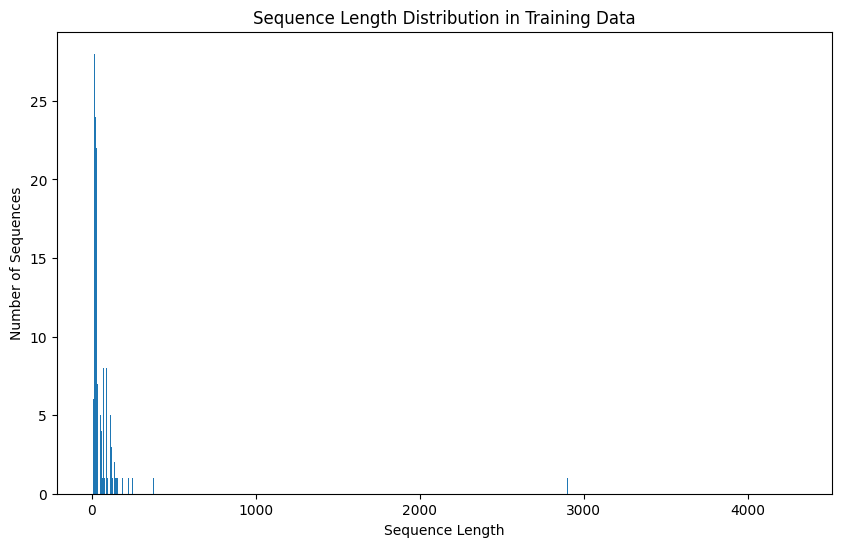

In [15]:
import matplotlib.pyplot as plt

# Sequence length distribution
train_seq['sequence_length'] = train_seq['sequence'].str.len()
sequence_length_counts = train_seq['sequence_length'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(sequence_length_counts.index, sequence_length_counts.values)
plt.xlabel('Sequence Length')
plt.ylabel('Number of Sequences')
plt.title('Sequence Length Distribution in Training Data')
plt.show()


### Count nucleotides

In [16]:
nucleotide_counts = {}
for seq in train_seq['sequence']:
    for nucleotide in seq:
        nucleotide_counts[nucleotide] = nucleotide_counts.get(nucleotide, 0) + 1
nucleotide_counts


{'G': 41450, 'U': 29178, 'C': 33937, 'A': 32524, '-': 4, 'X': 2}

In [17]:
# import re

# def clean_rna(seq):
#     return re.sub(r'[^ACGU]', '', seq.upper())

# train_seq['clean_sequence'] = train_seq['sequence'].apply(clean_rna)


In [18]:
# nucleotide_counts = {}
# for seq in train_seq['clean_sequence']:
#     for nucleotide in seq:
#         nucleotide_counts[nucleotide] = nucleotide_counts.get(nucleotide, 0) + 1
# nucleotide_counts

### cut off year distribution

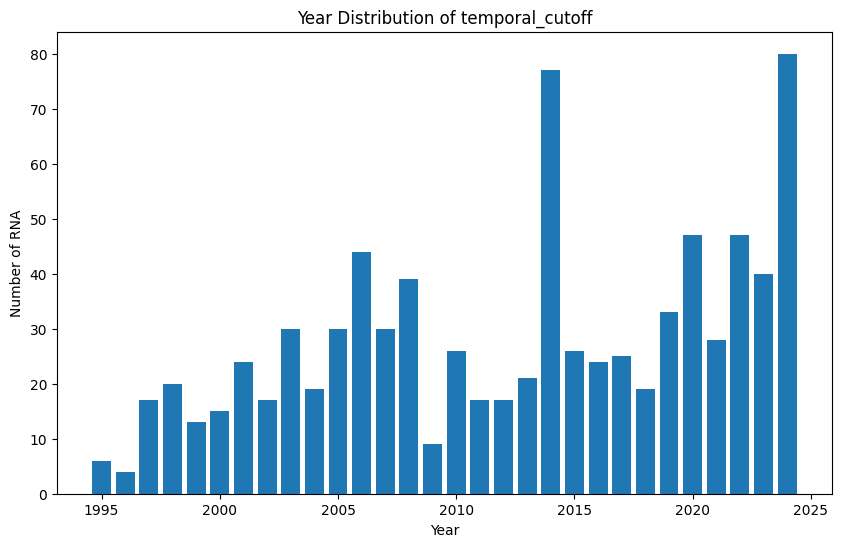

In [19]:
import matplotlib.pyplot as plt

def extract_year(date_string):
  """Extracts the year from a date string in 'yyyy-dd-mm' format."""
  try:
    return int(date_string.split('-')[0])
  except (IndexError, ValueError):
    return None

year_counts = train_seq['temporal_cutoff'].apply(extract_year).value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.bar(year_counts.index, year_counts.values)
plt.xlabel('Year')
plt.ylabel('Number of RNA')
plt.title('Year Distribution of temporal_cutoff')
plt.show()


## Train_Label

In [20]:
train_labels.head()

,ID,resname,resid,x_1,y_1,z_1
0,1SCL_A_1,G,1,13.760,-25.974001,0.102
1,1SCL_A_2,G,2,9.310,-29.638000,2.669
2,1SCL_A_3,G,3,5.529,-27.813000,5.878
3,1SCL_A_4,U,4,2.678,-24.900999,9.793
4,1SCL_A_5,G,5,1.827,-20.136000,11.793


In [21]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137095 entries, 0 to 137094
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   ID       137095 non-null  object 
 1   resname  137095 non-null  object 
 2   resid    137095 non-null  int64  
 3   x_1      130950 non-null  float64
 4   y_1      130950 non-null  float64
 5   z_1      130950 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 6.3+ MB


In [22]:
train_labels.isnull().sum()

ID            0
resname       0
resid         0
x_1        6145
y_1        6145
z_1        6145
dtype: int64

In [23]:
train_labels[['x_1', 'y_1', 'z_1']].describe()


,x_1,y_1,z_1
count,130950.000000,130950.000000,130950.000000
mean,80.447315,84.040727,98.611226
std,147.422319,114.928902,119.410665
min,-821.085999,-449.414001,-333.403992
25%,-1.115750,-4.890750,2.218500
50%,62.651501,67.901501,72.938499
75%,178.809753,170.451996,184.531750
max,849.887024,889.507996,668.776978


we assume those RNA can not fold into 3D strunture we will remove those RNA from train data

In [24]:
print(train_labels[train_labels.isnull().any(axis=1)])


               ID resname  resid  x_1  y_1  z_1
410      1ZDI_S_1       A      1  NaN  NaN  NaN
411      1ZDI_S_2       C      2  NaN  NaN  NaN
412      1ZDI_S_3       A      3  NaN  NaN  NaN
426     1ZDI_S_17       U     17  NaN  NaN  NaN
427     1ZDI_S_18       G     18  NaN  NaN  NaN
...           ...     ...    ...  ...  ...  ...
137090  8Z1F_T_82       U     82  NaN  NaN  NaN
137091  8Z1F_T_83       C     83  NaN  NaN  NaN
137092  8Z1F_T_84       A     84  NaN  NaN  NaN
137093  8Z1F_T_85       U     85  NaN  NaN  NaN
137094  8Z1F_T_86       A     86  NaN  NaN  NaN

[6145 rows x 6 columns]


In [25]:
print(train_labels['resname'].unique())

['G' 'U' 'C' 'A' '-' 'X']


list the id that we have to remove them

In [26]:
unuseable_id = train_labels[train_labels.isnull().any(axis=1)]['ID'].str.rsplit('_', n=1).str[0].unique()
print(len(unuseable_id))
print(unuseable_id)
unuseable_id_index = train_labels[train_labels.isnull().any(axis=1)]['ID'].unique()
print(len(unuseable_id_index))
print(unuseable_id_index)


238
['1ZDI_S' '7MSF_S' '5MSF_S' '1FOQ_A' '1E7K_D' '1IBM_Y' '1JWC_A' '1LS2_B'
 '1OSW_A' '1P6V_B' '1P6V_D' '1QZC_C' '1R2W_C' '1QZC_B' '1QZA_B' '1QZB_B'
 '1RY1_E' '1Y1Y_P' '1ZC8_Z' '1ZC8_G' '1ZC8_J' '1ZC8_F' '1ZC8_I' '1ZC8_H'
 '1X18_D' '1X18_A' '1X18_B' '1ZN1_B' '1YSH_F' '2A64_A' '2BQ5_S' '2BS0_R'
 '2BS0_S' '2B2E_R' '2B2E_S' '2AGN_C' '2AGN_A' '2IZN_S' '2IZ8_R' '2IZ8_S'
 '2DER_D' '2DET_C' '1ZBH_E' '2IY3_B' '2OB7_D' '2IL9_M' '2IL9_A' '2NR0_H'
 '2NR0_G' '2NR0_F' '2NR0_E' '2IZM_S' '2R93_R' '2OM7_J' '2R1G_C' '2R1G_A'
 '2R1G_X' '2R1G_F' '2R1G_B' '2R1G_E' '3EQ3_E' '3EQ3_Y' '3EP2_B' '3EP2_D'
 '3EQ4_A' '3EP2_C' '3CW1_v' '3HAY_E' '3A3A_A' '3IZD_A' '3PGW_N' '3PIP_Y'
 '2XXA_F' '3TUP_T' '2LC8_A' '3UZS_C' '4ILL_C' '3W1K_F' '3WC2_Q' '3WC2_P'
 '3WC1_Q' '4V5Z_BP' '4V6X_B2' '4V6W_B2' '4V6X_A5' '4V5Z_BA' '4V5G_BB'
 '4V5Z_BH' '4V5Z_BL' '4V5Z_BC' '4V6U_B1' '4V5Z_BK' '4V5Z_AH' '4V6W_A5'
 '4V5Z_BU' '4V5Z_BQ' '4V5Z_AF' '4V5Z_BM' '4QIL_C' '4OQ9_3' '2MNC_A'
 '3J8G_A' '4X4S_B' '4TUC_QY' '4TUA_XY' '2N0R_A' '4ZT9_D' 

In [27]:
clean_train_labels = train_labels[~train_labels['ID'].isin(unuseable_id_index)]
clean_train_seq = train_seq[~train_seq['target_id'].isin(unuseable_id)]

In [28]:
print(clean_train_labels[clean_train_labels.isnull().any(axis=1)])

Empty DataFrame
Columns: [ID, resname, resid, x_1, y_1, z_1]
Index: []


plot random 3D fold stucture

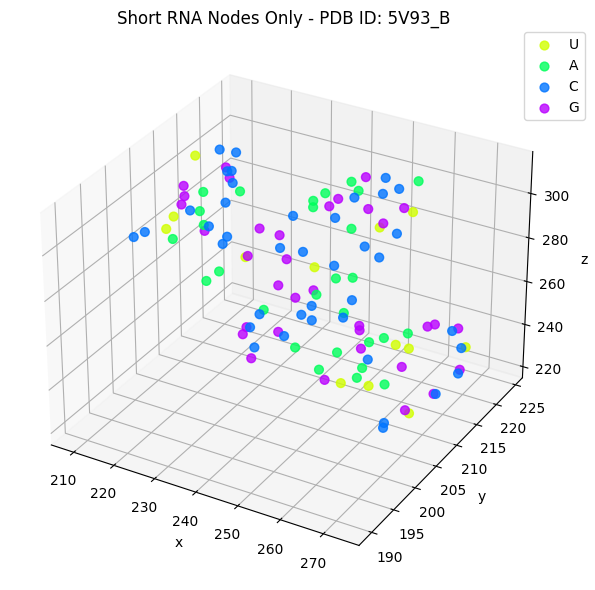

In [29]:
import random
import seaborn as sns
# Filter short RNAs with sequence length < 10
short_rna_ids = clean_train_seq[
    clean_train_seq['sequence'].str.len().between(100, 200)]['target_id'].unique()



# Select a random short RNA ID
random_short_id = random.choice(short_rna_ids)

# Get relevant rows
pdb_df = clean_train_labels[clean_train_labels['ID'].str.contains(random_short_id, na=False)]

# Setup color palette for each resname
unique_resnames = pdb_df['resname'].unique()
palette = sns.color_palette("hsv", len(unique_resnames))
resname_to_color = dict(zip(unique_resnames, palette))

# Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for resname in unique_resnames:
    coords = pdb_df[pdb_df['resname'] == resname]
    ax.scatter(coords['x_1'], coords['y_1'], coords['z_1'],
               label=resname, color=resname_to_color[resname], s=40, alpha=0.8)

ax.set_title(f'Short RNA Nodes Only - PDB ID: {random_short_id}')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

G-C Ratio

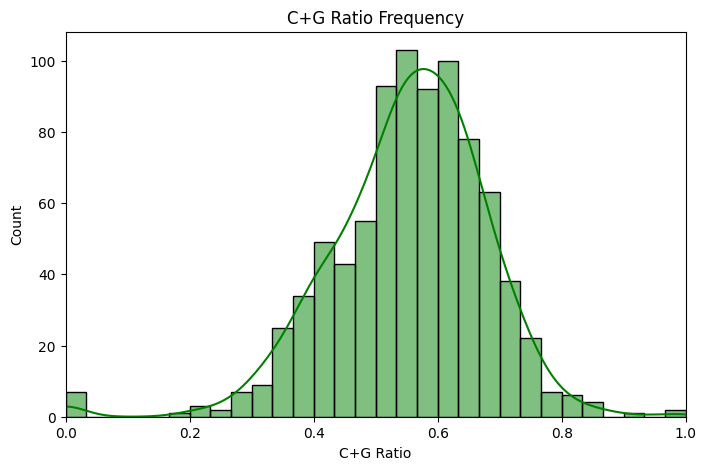

In [30]:
from collections import Counter

def CG_ratio(seq):
    if len(seq) == 0:
        return 0  # avoid division by zero
    nucleotide_counts = Counter(''.join(seq))
    return (nucleotide_counts.get('C', 0) + nucleotide_counts.get('G', 0)) / len(seq)

def plot_CG_ratio(df, desc, ax=None, color='blue'):
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
        created_fig = True
    sns.histplot(df['sequence'].apply(CG_ratio), kde=True, ax=ax, color=color)
    ax.set_title('C+G Ratio Frequency')
    ax.set_xlabel('C+G Ratio')
    ax.set_xlim(0, 1)

plot_CG_ratio(train_seq, 'Train', color='green')


Preprocess for MLP

In [31]:
clean_train_labels['target_id'] = clean_train_labels['ID'].apply(lambda x: '_'.join(x.split('_')[:2]))

merged = clean_train_labels.merge(train_seq[['target_id', 'sequence']], on='target_id', how='left')

print(merged.head())

         ID resname  resid     x_1        y_1     z_1 target_id  \
0  1SCL_A_1       G      1  13.760 -25.974001   0.102    1SCL_A   
1  1SCL_A_2       G      2   9.310 -29.638000   2.669    1SCL_A   
2  1SCL_A_3       G      3   5.529 -27.813000   5.878    1SCL_A   
3  1SCL_A_4       U      4   2.678 -24.900999   9.793    1SCL_A   
4  1SCL_A_5       G      5   1.827 -20.136000  11.793    1SCL_A   

                        sequence  
0  GGGUGCUCAGUACGAGAGGAACCGCACCC  
1  GGGUGCUCAGUACGAGAGGAACCGCACCC  
2  GGGUGCUCAGUACGAGAGGAACCGCACCC  
3  GGGUGCUCAGUACGAGAGGAACCGCACCC  
4  GGGUGCUCAGUACGAGAGGAACCGCACCC  


C:\Users\temmy\AppData\Local\Temp\ipykernel_12872\2929307691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_train_labels['target_id'] = clean_train_labels['ID'].apply(lambda x: '_'.join(x.split('_')[:2]))


In [32]:
merged.isna().sum()

ID           0
resname      0
resid        0
x_1          0
y_1          0
z_1          0
target_id    0
sequence     0
dtype: int64

finding outlier

In [33]:
import numpy as np

# Calculate Q1, Q3, and IQR for each coordinate
Q1 = np.percentile(merged[['x_1', 'y_1', 'z_1']], 25, axis=0)
Q3 = np.percentile(merged[['x_1', 'y_1', 'z_1']], 75, axis=0)
IQR = Q3 - Q1

# Identify outliers (points outside the 1.5 * IQR range)
outliers = ((merged[['x_1', 'y_1', 'z_1']] < (Q1 - 1.5 * IQR)) | (merged[['x_1', 'y_1', 'z_1']] > (Q3 + 1.5 * IQR)))
outlier_indices = np.where(np.any(outliers, axis=1))[0]

print(f"Outliers detected at indices: {outlier_indices}")


Outliers detected at indices: [  7697   7698   7699 ... 129603 129604 129605]


In [34]:
total_data_points = merged.shape[0]
outlier_count = len(outlier_indices)
outlier_percentage = (outlier_count / total_data_points) * 100
print(f"Percentage of outliers: {outlier_percentage:.2f}%")

Percentage of outliers: 1.53%


In [35]:
outlier_target_ids = merged.iloc[outlier_indices]['target_id'].unique()
outlier_target_ids

array(['2EVY_A', '2GRW_A', '2GV4_A', '2OJ8_A', '4V4G_CA', '5V17_A',
       '6EVJ_V', '6FHI_V', '6AEB_E', '6Z6B_UUU', '9G8O_S2'], dtype=object)

per-nucleotide one-hot encoding

In [36]:
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

encoder = OneHotEncoder(categories=[['A', 'C', 'G', 'U']], handle_unknown='ignore', sparse_output=False)
encoder.fit(np.array(list("ACGU")).reshape(-1, 1))

encoded_sequences = [encoder.transform(np.array(list(seq)).reshape(-1, 1)) for seq in train_seq['sequence']]

train_seq['encoded'] = encoded_sequences
train_labels['target_id'] = train_labels['ID'].apply(lambda x: '_'.join(x.split('_')[:2]))
merged_df = pd.merge(train_labels, train_seq[['target_id', 'encoded','sequence']], on='target_id', how='left')

val_seq['encoded'] = [encoder.transform(np.array(list(seq)).reshape(-1, 1)) for seq in val_seq['sequence']]
val_labels['target_id'] = val_labels['ID'].apply(lambda x: '_'.join(x.split('_')[:1]))
merged_val_df = pd.merge(val_labels, val_seq[['target_id', 'encoded','sequence']], on='target_id', how='left')


In [37]:
merged_val_df.head()

,ID,resname,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,...,z_38,x_39,y_39,z_39,x_40,y_40,z_40,target_id,encoded,sequence
0,R1107_1,G,1,-5.499,8.520000,8.605000,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,R1107,"[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...",GGGGGCCACAGCAGAAGCGUUCACGUCGCAGCCCCUGUCAGCCAUU...
1,R1107_2,G,2,-5.826,10.453000,14.010000,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,R1107,"[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...",GGGGGCCACAGCAGAAGCGUUCACGUCGCAGCCCCUGUCAGCCAUU...
2,R1107_3,G,3,-5.849,14.768000,17.584999,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,R1107,"[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...",GGGGGCCACAGCAGAAGCGUUCACGUCGCAGCCCCUGUCAGCCAUU...
3,R1107_4,G,4,-5.784,19.985001,18.666000,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,R1107,"[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...",GGGGGCCACAGCAGAAGCGUUCACGUCGCAGCCCCUGUCAGCCAUU...
4,R1107_5,G,5,-5.755,25.533001,17.132999,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,R1107,"[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...",GGGGGCCACAGCAGAAGCGUUCACGUCGCAGCCCCUGUCAGCCAUU...


In [38]:
merged_df.head()

,ID,resname,resid,x_1,y_1,z_1,target_id,encoded,sequence
0,1SCL_A_1,G,1,13.760,-25.974001,0.102,1SCL_A,"[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...",GGGUGCUCAGUACGAGAGGAACCGCACCC
1,1SCL_A_2,G,2,9.310,-29.638000,2.669,1SCL_A,"[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...",GGGUGCUCAGUACGAGAGGAACCGCACCC
2,1SCL_A_3,G,3,5.529,-27.813000,5.878,1SCL_A,"[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...",GGGUGCUCAGUACGAGAGGAACCGCACCC
3,1SCL_A_4,U,4,2.678,-24.900999,9.793,1SCL_A,"[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...",GGGUGCUCAGUACGAGAGGAACCGCACCC
4,1SCL_A_5,G,5,1.827,-20.136000,11.793,1SCL_A,"[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...",GGGUGCUCAGUACGAGAGGAACCGCACCC


In [39]:
merged_df.isna().sum()

ID              0
resname         0
resid           0
x_1          6145
y_1          6145
z_1          6145
target_id       0
encoded         0
sequence        0
dtype: int64

In [40]:
merged_df.dropna(inplace=True)

In [41]:
merged_val_df.head()

,ID,resname,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,...,z_38,x_39,y_39,z_39,x_40,y_40,z_40,target_id,encoded,sequence
0,R1107_1,G,1,-5.499,8.520000,8.605000,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,R1107,"[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...",GGGGGCCACAGCAGAAGCGUUCACGUCGCAGCCCCUGUCAGCCAUU...
1,R1107_2,G,2,-5.826,10.453000,14.010000,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,R1107,"[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...",GGGGGCCACAGCAGAAGCGUUCACGUCGCAGCCCCUGUCAGCCAUU...
2,R1107_3,G,3,-5.849,14.768000,17.584999,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,R1107,"[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...",GGGGGCCACAGCAGAAGCGUUCACGUCGCAGCCCCUGUCAGCCAUU...
3,R1107_4,G,4,-5.784,19.985001,18.666000,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,R1107,"[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...",GGGGGCCACAGCAGAAGCGUUCACGUCGCAGCCCCUGUCAGCCAUU...
4,R1107_5,G,5,-5.755,25.533001,17.132999,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,R1107,"[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...",GGGGGCCACAGCAGAAGCGUUCACGUCGCAGCCCCUGUCAGCCAUU...


In [42]:
merged_val_df.isna().sum()

ID           0
resname      0
resid        0
x_1          0
y_1          0
            ..
y_40         0
z_40         0
target_id    0
encoded      0
sequence     0
Length: 126, dtype: int64

In [43]:
res_encoder = OneHotEncoder(categories=[['A', 'C', 'G', 'U']], handle_unknown='ignore', sparse_output=False)
res_encoder.fit(np.array(list("ACGU")).reshape(-1, 1))

OneHotEncoder(categories=[['A', 'C', 'G', 'U']], handle_unknown='ignore',
              sparse_output=False)

#### pool avg padding

In [ ]:
# all_encoded = merged_df['encoded'].tolist()
# pooled_encoded = [np.mean(seq, axis=0) for seq in all_encoded]  # (4 dim vector)

# # 2. Create X_train
# X_train = np.array([
#     np.concatenate([
#         res_encoder.transform([[row.resname]])[0],  # one-hot resname (4,)
#         [row.resid],                                # raw resid (later normalize)
#         pooled_encoded[idx]                         # averaged sequence vector (4,)
#     ])
#     for idx, row in enumerate(merged_df.itertuples(index=False))
# ], dtype='float32')



In [ ]:
# pooled_encoded_val = [np.mean(seq, axis=0) for seq in merged_val_df['encoded']]

# X_val = np.array([
#     np.concatenate([
#         res_encoder.transform([[row.resname]])[0],  # one-hot resname (4,)
#         [row.resid],                                # raw resid (later normalize)
#         pooled_encoded_val[idx]                     # average sequence (4,)
#     ])
#     for idx, row in enumerate(merged_val_df.itertuples(index=False))
# ], dtype='float32')

#### One-Hot paddong my pc cant handle this

In [ ]:
# import numpy as np
# from sklearn.preprocessing import OneHotEncoder
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# # --- Setup ---

# # Prepare OneHotEncoder for ACGU
# encoder = OneHotEncoder(categories=[['A', 'C', 'G', 'U']], handle_unknown='ignore', sparse_output=False)
# encoder.fit(np.array(list('ACGU')).reshape(-1, 1))

# # Encode train sequences
# encoded_sequences = [
#     encoder.transform(np.array(list(seq)).reshape(-1, 1))
#     for seq in train_seq['sequence']
# ]

# # Encode validation sequences
# encoded_val_sequences = [
#     encoder.transform(np.array(list(seq)).reshape(-1, 1))
#     for seq in val_seq['sequence']
# ]

# # Padding sequences
# max_len = max(
#     max(len(seq) for seq in encoded_sequences),
#     max(len(seq) for seq in encoded_val_sequences)
# )

# padded_encoded = pad_sequences(encoded_sequences, maxlen=max_len, padding='post', dtype='float32')
# padded_encoded_val = pad_sequences(encoded_val_sequences, maxlen=max_len, padding='post', dtype='float32')

# # Create mapping target_id -> sequence
# target_to_sequence_train = dict(zip(train_seq['target_id'], padded_encoded))
# target_to_sequence_val = dict(zip(val_seq['target_id'], padded_encoded_val))

# # Find max resid from train
# max_resid = merged_df['resid'].max()

# # Create X_train
# X_train = np.array([
#     np.concatenate([
#         res_encoder.transform([[row.resname]])[0],            # one-hot resname
#         [row.resid / max_resid],                              # normalized resid
#         target_to_sequence_train[row.target_id].flatten()     # flatten padded sequence
#     ])
#     for _, row in merged_df.iterrows()
# ], dtype='float32')

# # Create X_val
# X_val = np.array([
#     np.concatenate([
#         res_encoder.transform([[row.resname]])[0],
#         [row.resid / max_resid],
#         target_to_sequence_val[row.target_id].flatten()
#     ])
#     for _, row in merged_val_df.iterrows()
# ], dtype='float32')

# print(f"X_train shape: {X_train.shape}")
# print(f"X_val shape: {X_val.shape}")


#### Area Padding 

In [47]:
X_train[0]

array([0.        , 0.        , 1.        , 0.        , 1.        ,
       0.2413793 , 0.31034482, 0.3448276 , 0.10344828], dtype=float32)

In [48]:
y_train = merged_df[['x_1', 'y_1', 'z_1']].values
print(y_train.shape)

(130950, 3)


In [49]:
y_val = merged_val_df[['x_1', 'y_1', 'z_1']].values
print(y_val.shape)

(2515, 3)


In [50]:
from sklearn.preprocessing import MinMaxScaler
scaler_resid = MinMaxScaler()

X_train[:, 4:5] = scaler_resid.fit_transform(X_train[:, 4:5])
X_val[:, 4:5] = scaler_resid.transform(X_val[:, 4:5])

In [51]:
print(np.max(X_val), np.min(X_val))
print(np.max(y_val), np.min(y_val))


1.0 0.0
288.6700134277344 -1e+18


In [52]:
y_val[y_val == -1e18] = 0

In [53]:
from sklearn.preprocessing import MinMaxScaler
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)

In [54]:
print(np.min(y_val), np.max(y_val))
print(np.min(y_train), np.max(y_train))

-65.48999786376953 288.6700134277344
-821.0859985351562 889.5079956054688


In [55]:
print(X_train.shape)
print(y_train.shape)


(130950, 9)
(130950, 3)


In [56]:
print(X_val.shape)
print(y_val.shape)

(2515, 9)
(2515, 3)


### MLP Model for Regression (predicting x, y, z) With out removing RNA that contein outlier


In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Model
model = Sequential([
    Input(shape=(49,)),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(3)  # output x, y, z
])

# Compile
optimizer = Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, verbose=1)

# Fit
history = model.fit(
    X_train, y_train_scaled,
    validation_data=(X_val, y_val_scaled),
    epochs=150,
    batch_size=256,
    callbacks=[early_stop, reduce_lr]
)





Epoch 1/150
512/512 [==============================] - 3s 3ms/step - loss: 0.2812 - mae: 0.3567 - val_loss: 0.0096 - val_mae: 0.0829 - lr: 0.0010
Epoch 2/150
512/512 [==============================] - 2s 3ms/step - loss: 0.0195 - mae: 0.1077 - val_loss: 0.0063 - val_mae: 0.0696 - lr: 0.0010
Epoch 3/150
512/512 [==============================] - 2s 3ms/step - loss: 0.0112 - mae: 0.0829 - val_loss: 0.0057 - val_mae: 0.0663 - lr: 0.0010
Epoch 4/150
512/512 [==============================] - 2s 3ms/step - loss: 0.0101 - mae: 0.0791 - val_loss: 0.0053 - val_mae: 0.0639 - lr: 0.0010
Epoch 5/150
512/512 [==============================] - 2s 3ms/step - loss: 0.0099 - mae: 0.0784 - val_loss: 0.0050 - val_mae: 0.0620 - lr: 0.0010
Epoch 6/150
512/512 [==============================] - 2s 3ms/step - loss: 0.0098 - mae: 0.0785 - val_loss: 0.0053 - val_mae: 0.0639 - lr: 0.0010
Epoch 7/150
512/512 [==============================] - 2s 3ms/step - loss: 0.0099 - mae: 0.0784 - val_loss: 0.0052 - val_mae

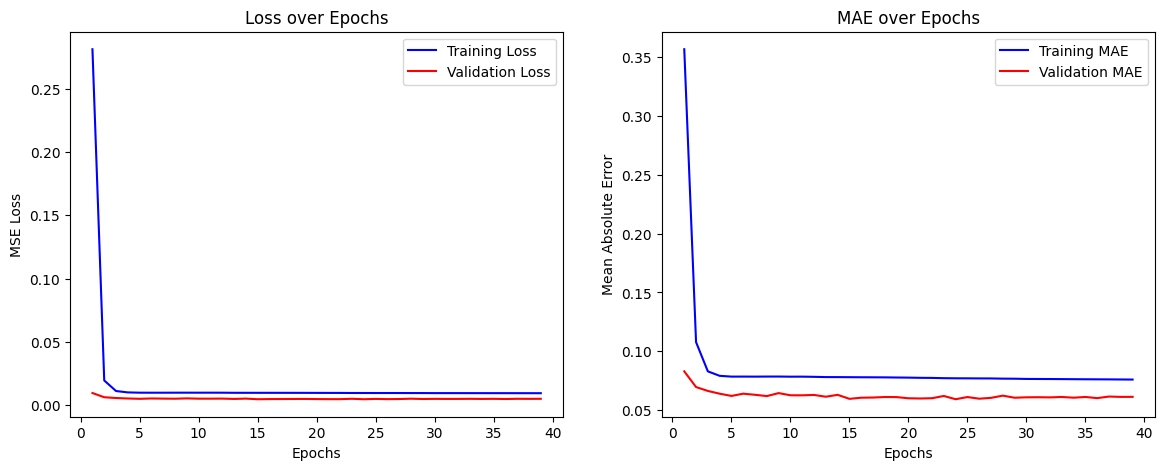

In [72]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']

epochs = range(1, len(loss) + 1)

# Plot Loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, mae, 'b-', label='Training MAE')
plt.plot(epochs, val_mae, 'r-', label='Validation MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.show()

# evaluate_regression

In [73]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_regression(y_true, y_pred):
    results = {}

    # For each output dimension (x, y, z)
    axis_names = ['X', 'Y', 'Z']
    for i in range(y_true.shape[1]):
        r2 = r2_score(y_true[:, i], y_pred[:, i])
        rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])

        results[axis_names[i]] = {
            'R2': round(r2, 4),
            'RMSE': round(rmse, 4),
            'MAE': round(mae, 4)
        }

    return results


In [74]:
# Predict และ inverse แล้ว
y_val_true = scaler_y.inverse_transform(y_val_scaled)
y_pred = scaler_y.inverse_transform(model.predict(X_val))

metrics = evaluate_regression(y_val_true, y_pred)

for axis, values in metrics.items():
    print(f"Results for {axis}-axis:")
    for metric_name, value in values.items():
        print(f"  {metric_name}: {value}")
    print()


79/79 [==============================] - 0s 736us/step
Results for X-axis:
  R2: -0.2003
  RMSE: 84.618
  MAE: 77.4041

Results for Y-axis:
  R2: -0.1662
  RMSE: 83.9148
  MAE: 74.903

Results for Z-axis:
  R2: -0.0636
  RMSE: 87.5118
  MAE: 75.5453



### CNN for Regression (predicting x, y, z) With out removing RNA that contein outlier


due to too much of feature ~17k features  we have to change the input... ig

In [63]:
def extract_window(seq_encoded, center_idx, window_size=5):
    """
    Extract a window of one-hot encoded sequence centered around the residue.
    
    Args:
        seq_encoded (np.array): (seq_len, 4)
        center_idx (int): center position (0-based).
        window_size (int): how far to look left/right.

    Returns:
        np.array: (2*window_size+1, 4) flattened
    """
    seq_len = seq_encoded.shape[0]
    window = []

    for i in range(center_idx - window_size, center_idx + window_size + 1):
        if 0 <= i < seq_len:
            window.append(seq_encoded[i])
        else:
            window.append(np.zeros(4))  # padding zeros if out of bound

    return np.array(window)

# -----------------------------------------------------
# Create X_train
# -----------------------------------------------------

# สมมติว่า res_encoder fit เรียบร้อยแล้วนะ

max_resid = merged_df['resid'].max()  # normalize resid

window_size = 5  # set ขนาด window

X_train = np.array([
    np.concatenate([
        res_encoder.transform([[row.resname]])[0],         # one-hot resname (4,)
        [row.resid / max_resid],                           # normalized resid (1,)
        extract_window(row.encoded, row.resid - 1, window_size).flatten()  # window
    ])
    for _, row in merged_df.iterrows()
], dtype='float32')

# -----------------------------------------------------
# Create X_val
# -----------------------------------------------------

max_resid_val = merged_val_df['resid'].max()  # หรือจะใช้ max_resid train ก็ได้ถ้าอยาก maintain scale

X_val = np.array([
    np.concatenate([
        res_encoder.transform([[row.resname]])[0],         # one-hot resname (4,)
        [row.resid / max_resid_val],                       # normalized resid (1,)
        extract_window(row.encoded, row.resid - 1, window_size).flatten()
    ])
    for _, row in merged_val_df.iterrows()
], dtype='float32')

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")



X_train shape: (130950, 49)
X_val shape: (2515, 49)


In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- Model ---
model = Sequential([
    Input(shape=(49, 1)),  # 9 feature
    
    Conv1D(64, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),
    
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),
    
    Conv1D(256, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.2),
    
    GlobalAveragePooling1D(),
    
    Dense(64, activation='relu'),
    Dropout(0.2),
    
    Dense(3)  # output: x, y, z
])

# --- Compile ---
optimizer = Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# --- Callbacks ---
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, verbose=1)

# --- Train ---
history = model.fit(
    X_train.reshape(-1, 49, 1),   # <<< แก้ตรงนี้ให้ถูก
    y_train_scaled,
    validation_data=(X_val.reshape(-1, 49, 1), y_val_scaled),
    epochs=150,
    batch_size=256,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/150
512/512 [==============================] - 57s 110ms/step - loss: 0.0202 - mae: 0.1067 - val_loss: 0.0054 - val_mae: 0.0610 - lr: 0.0010
Epoch 2/150
512/512 [==============================] - 71s 140ms/step - loss: 0.0118 - mae: 0.0849 - val_loss: 0.0060 - val_mae: 0.0686 - lr: 0.0010
Epoch 3/150
512/512 [==============================] - 91s 177ms/step - loss: 0.0108 - mae: 0.0813 - val_loss: 0.0048 - val_mae: 0.0605 - lr: 0.0010
Epoch 4/150
512/512 [==============================] - 97s 189ms/step - loss: 0.0103 - mae: 0.0795 - val_loss: 0.0056 - val_mae: 0.0661 - lr: 0.0010
Epoch 5/150
512/512 [==============================] - 100s 195ms/step - loss: 0.0100 - mae: 0.0786 - val_loss: 0.0051 - val_mae: 0.0629 - lr: 0.0010
Epoch 6/150
512/512 [==============================] - 101s 198ms/step - loss: 0.0098 - mae: 0.0781 - val_loss: 0.0050 - val_mae: 0.0621 - lr: 0.0010
Epoch 7/150
512/512 [==============================] - 93s 181ms/step - loss: 0.0097 - mae: 0.0779 - val

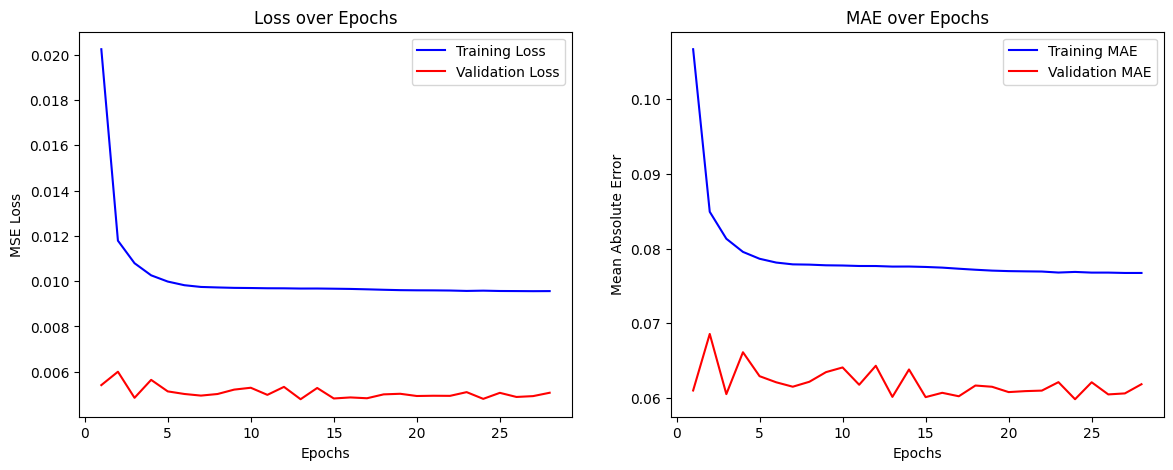

In [68]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']

epochs = range(1, len(loss) + 1)

# Plot Loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, mae, 'b-', label='Training MAE')
plt.plot(epochs, val_mae, 'r-', label='Validation MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.show()

In [69]:
# Predict และ inverse แล้ว
y_val_true = scaler_y.inverse_transform(y_val_scaled)
y_pred = scaler_y.inverse_transform(model.predict(X_val))

metrics = evaluate_regression(y_val_true, y_pred)

for axis, values in metrics.items():
    print(f"Results for {axis}-axis:")
    for metric_name, value in values.items():
        print(f"  {metric_name}: {value}")
    print()


79/79 [==============================] - 0s 3ms/step
Results for X-axis:
  R2: -0.2161
  RMSE: 85.1712
  MAE: 78.3364

Results for Y-axis:
  R2: -0.2349
  RMSE: 86.352
  MAE: 77.9724

Results for Z-axis:
  R2: -0.0597
  RMSE: 87.3521
  MAE: 75.5152



# KIM's MODEL

In [67]:
import pandas as pd
import tensorflow as tf
import numpy as np

# 1. โหลด CSV
df = pd.read_csv(data_path+'/train_sequences.csv')

# สมมติว่า column ชื่อ 'sequence'
sequences = df['sequence'].tolist()

print("Sequences ที่อ่านมาจาก CSV:")
print(sequences)

# 2. เขียน Mapping ACGU เป็นตัวเลข
char_to_int = {'A': 1, 'C': 2, 'G': 3, 'U': 4}
pad_token = 0

def encode_sequence(seq):
    return [char_to_int.get(ch, pad_token) for ch in seq]

encoded_sequences = [encode_sequence(seq) for seq in sequences]

print("\nEncoded Sequences (ก่อน Padding):")
for seq in encoded_sequences:
    print(seq)

# 3. Padding
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    encoded_sequences,
    padding='post',
    value=pad_token
)

print("\nSequences หลัง Padding:")
print(padded_sequences)

# 4. สมมติ Labels สำหรับเทรนตัวอย่าง
labels = np.random.randint(0, 2, size=(len(sequences),))  # สุ่ม label 0 หรือ 1

# 5. สร้าง Tensorflow Dataset
dataset = tf.data.Dataset.from_tensor_slices((padded_sequences, labels))
dataset = dataset.shuffle(buffer_size=100).batch(2)

# 6. สร้าง Model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5, output_dim=8, mask_zero=True),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# 7. Compile Model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 8. Train Model
model.fit(dataset, epochs=10)


Sequences ที่อ่านมาจาก CSV:
['GGGUGCUCAGUACGAGAGGAACCGCACCC', 'GGCGCAGUGGGCUAGCGCCACUCAAAAGGCCCAU', 'GGGACUGACGAUCACGCAGUCUAU', 'GGGAUAACUUCGGUUGUCCC', 'GGCGACCCUGAUGAGGCCGAAAGGCCGAAACCGU', 'GGCGCUUGCGUC', 'GGCCGAAACUCGUAAGAGUCACCAC', 'GGCGCAGUGGGCUAGCGCCACUCAAAAGCCCG', 'UUACCCAAGUUUGAGGUAA', 'GGCUCGUGUAGCUCAUUAGCUCCGAGCC', 'GGCAGAUCUGAGCCUGGGAGCUCUCUGCC', 'GGGCGAGAGCCU', 'GGGCGCAAGCCU', 'GGUCUGGGCGCAGCGCAAGCUGACGGUACAGGCC', 'GGGCGAAAGCCU', 'GGCGCAGUGGGCUAGCGCCACUCAAAGGCCCG', 'GGGGCUCUUCGGAGCUCCACCA', 'ACAUGAGGAUUACCCAUGU', 'GGUGUGAACACC', 'GGUGGGCGCAGCUUCGGCUGCGGUACACC', 'GGUGGGCGCAGCUUCGGCUGACGGUACACC', 'GGCUGGACUCGUACUUCGGUACUGGAGAAACAGCC', 'GCUGUUCCCAGACAGC', 'GAGCCCUGGGAGGCUC', 'GGCACCUCCUCGCGGUGCC', 'GGCCUAAGACUUCGGUUAUGGCC', 'GACUGGGGCGGUC', 'GGAGUGCUUCAACAGUGCUUGGACGCUCC', 'GGGACCAGAAGGUCCCG', 'GCUCCAGAUGGAGCG', 'GGCGUACGUUUCGUACGCC', 'GGCAGAGUCCUUCGGGACAUUGCACCUGCC', 'GGUCAGUGUAACAACUGACC', 'GCGCUGACAAAGCGC', 'GGGAGCUCAACUCUCCCCCCCUUUUCCGAGGGUCAUCGGAACCA', 'GGCCGAUGGUAGUGUGGGG

KeyboardInterrupt: 

In [ ]:
# สร้าง ANN
ann_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(padded_sequences.shape[1],)),  # เปลี่ยน sequence ให้เป็น vector
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')  # ทำนาย 2 classes
])

ann_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nเทรน ANN Model:")
history_ann = ann_model.fit(dataset, epochs=10)



เทรน ANN Model:
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 998us/step - accuracy: 0.5104 - loss: 0.9710
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4878 - loss: 0.7651
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4710 - loss: 0.7069
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5474 - loss: 0.6938
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5729 - loss: 0.6988
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.5707 - loss: 0.6866
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5466 - loss: 0.6833
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5874 - loss: 0.6796
Epoch 9/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5646 - loss: 0.6817
Epoch 10/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5189 - loss: 0.7036


In [ ]:
# สร้าง CNN
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5, output_dim=8, mask_zero=True, input_length=padded_sequences.shape[1]),
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nเทรน CNN Model:")
history_cnn = cnn_model.fit(dataset, epochs=10)



เทรน CNN Model:
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_12' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4722 - loss: 0.6948
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4936 - loss: 0.6937
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5270 - loss: 0.6928
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5210 - loss: 0.6928
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5196 - loss: 0.6928
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5229 - loss: 0.6932
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5302 - loss: 0.6935
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5118 - loss: 0.6932
Epoch 9/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5110 - loss: 0.6931
Epoch 10/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5151 - loss: 0.6930


In [ ]:
def plot_training_history(history, title='Model'):
    acc = history.history['accuracy']
    loss = history.history['loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{title} Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title} Loss')
    plt.legend()

    plt.show()


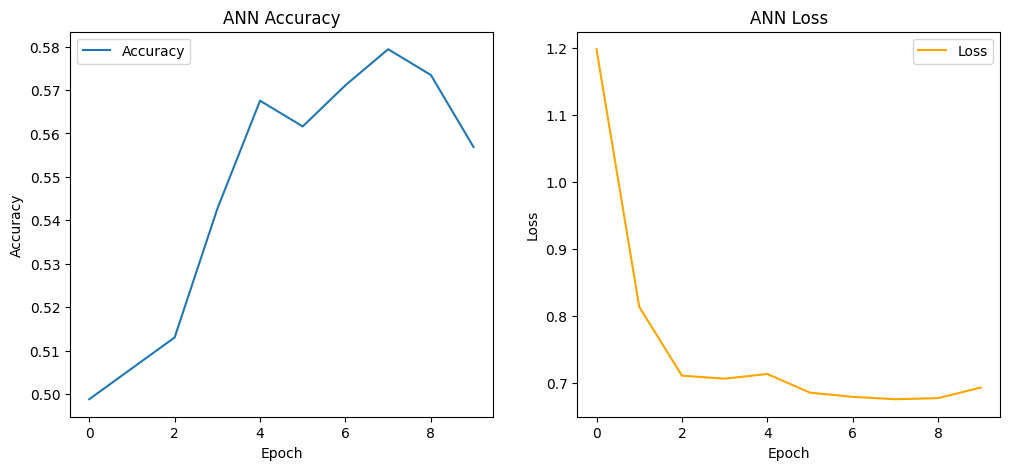

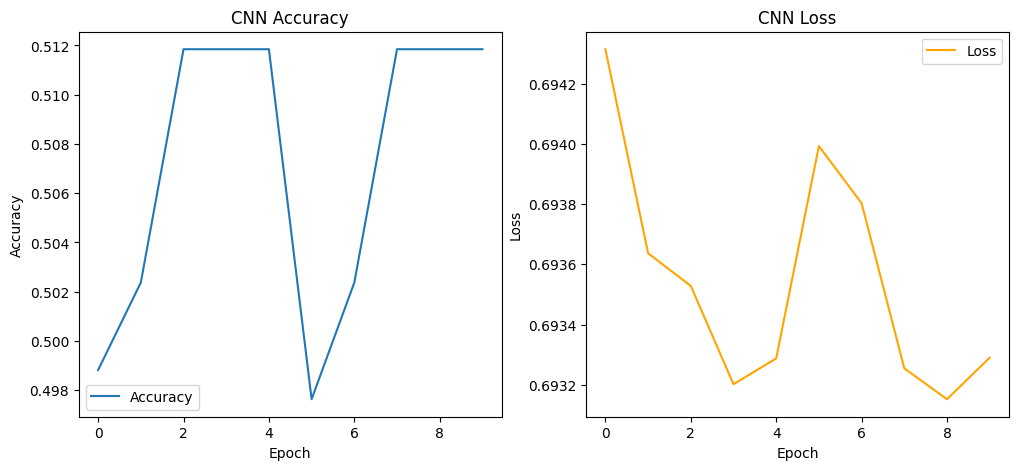

In [ ]:
# วาดกราฟของ ANN
plot_training_history(history_ann, title='ANN')

# วาดกราฟของ CNN
plot_training_history(history_cnn, title='CNN')


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# สร้าง EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # ติดตามค่า val_loss
    patience=3,  # ถ้า val_loss ไม่ดีขึ้นภายใน 3 epoch ให้หยุด
    restore_best_weights=True  # นำโมเดลที่ดีที่สุดกลับมา
)

# เทรน ANN พร้อม EarlyStopping
print("\nเทรน ANN Model:")
history_ann = ann_model.fit(dataset, epochs=10, validation_data=dataset, callbacks=[early_stopping])

# เทรน CNN พร้อม EarlyStopping
print("\nเทรน CNN Model:")
history_cnn = cnn_model.fit(dataset, epochs=10, validation_data=dataset, callbacks=[early_stopping])



เทรน ANN Model:
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5629 - loss: 0.6750 - val_accuracy: 0.6232 - val_loss: 0.6505
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5591 - loss: 0.6716 - val_accuracy: 0.6339 - val_loss: 0.6499
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6111 - loss: 0.6678 - val_accuracy: 0.6268 - val_loss: 0.6456
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6054 - loss: 0.6620 - val_accuracy: 0.6363 - val_loss: 0.6413
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6162 - loss: 0.6535 - val_accuracy: 0.6102 - val_loss: 0.6456
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6111 - loss: 0.6573 - val_accuracy: 0.6434 - val_loss: 0.6277
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5909 - loss: 0.6511 - val_accuracy: 0.6363 - val_loss: 0.6251
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6197 - loss: 0.6459 -

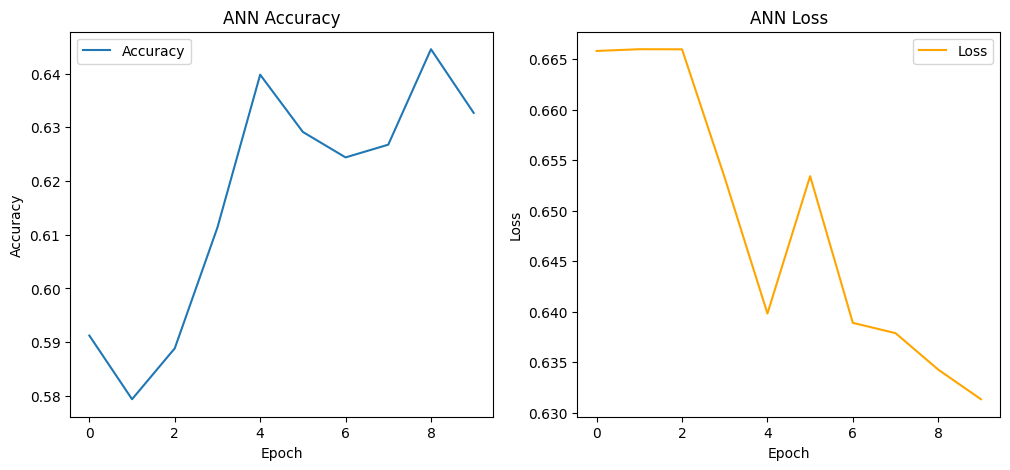

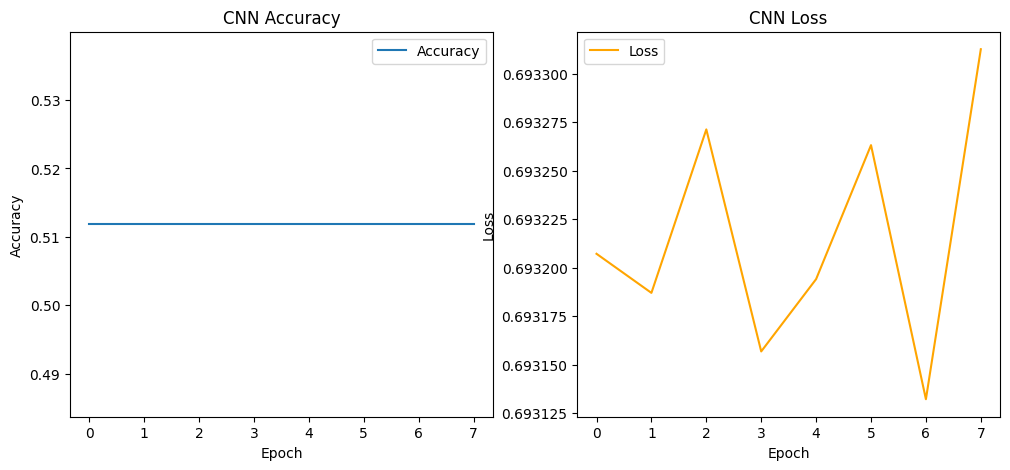

In [ ]:
# วาดกราฟของ ANN
plot_training_history(history_ann, title='ANN')

# วาดกราฟของ CNN
plot_training_history(history_cnn, title='CNN')


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

ann_accuracies = []
cnn_accuracies = []

for train_index, val_index in kf.split(padded_sequences):
    print(f"\nFold {fold}")
    
    # แบ่งข้อมูล train และ validation
    X_train, X_val = np.array(padded_sequences)[train_index], np.array(padded_sequences)[val_index]
    y_train, y_val = np.array(labels)[train_index], np.array(labels)[val_index]

    # สร้าง TensorFlow Dataset สำหรับ Train และ Validation
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(2)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(2)
    
    # สร้าง ANN Model ใหม่
    ann_model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # สร้าง CNN Model ใหม่
    cnn_model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=5, output_dim=8, mask_zero=True, input_length=X_train.shape[1]),
        tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # สร้าง EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

    # เทรนโมเดล ANN
    ann_history = ann_model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping])
    ann_accuracies.append(ann_history.history['val_accuracy'][-1])  # เก็บผล val_accuracy
    
    # เทรนโมเดล CNN
    cnn_history = cnn_model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping])
    cnn_accuracies.append(cnn_history.history['val_accuracy'][-1])  # เก็บผล val_accuracy
    
    fold += 1

# แสดงผลค่าเฉลี่ยของ accuracy ของแต่ละ fold
print(f"\nAverage accuracy for ANN: {np.mean(ann_accuracies)}")
print(f"Average accuracy for CNN: {np.mean(cnn_accuracies)}")



Fold 1
Epoch 1/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4989 - loss: 1.0175 - val_accuracy: 0.4970 - val_loss: 0.7156
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5215 - loss: 0.7225 - val_accuracy: 0.4734 - val_loss: 0.7113
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5068 - loss: 0.6936 - val_accuracy: 0.4911 - val_loss: 0.6987
Epoch 4/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5552 - loss: 0.6832 - val_accuracy: 0.4852 - val_loss: 0.6998
Epoch 5/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5551 - loss: 0.6789 - val_accuracy: 0.4734 - val_loss: 0.6959
Epoch 6/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5486 - loss: 0.7122 - val_accuracy: 0.4793 - val_loss: 0.7060
Epoch 7/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5668 - loss: 0.6780 - val_accuracy: 0.4497 - val_loss: 0.7141
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_14' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4514 - loss: 0.6961 - val_accuracy: 0.5148 - val_loss: 0.6928
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4975 - loss: 0.6942 - val_accuracy: 0.5148 - val_loss: 0.6929
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4590 - loss: 0.6940 - val_accuracy: 0.5148 - val_loss: 0.6928
Epoch 4/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5112 - loss: 0.6934 - val_accuracy: 0.5148 - val_loss: 0.6928
Epoch 5/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5112 - loss: 0.6934 - val_accuracy: 0.5148 - val_loss: 0.6928
Epoch 6/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5112 - loss: 0.6934 - val_accuracy: 0.5148 - val_loss: 0.6928
Epoch 7/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5112 - loss: 0.6934 - val_accuracy: 0.5148 - val_loss: 0.6927
Epoch 8/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5112 - loss: 0.6934 - val_accuracy: 0.5148 - val_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_16' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4740 - loss: 0.6956 - val_accuracy: 0.5385 - val_loss: 0.6930
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4693 - loss: 0.6940 - val_accuracy: 0.5385 - val_loss: 0.6925
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4538 - loss: 0.6937 - val_accuracy: 0.5385 - val_loss: 0.6925
Epoch 4/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4686 - loss: 0.6937 - val_accuracy: 0.5385 - val_loss: 0.6925
Epoch 5/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4752 - loss: 0.6936 - val_accuracy: 0.5385 - val_loss: 0.6925
Epoch 6/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4886 - loss: 0.6936 - val_accuracy: 0.5385 - val_loss: 0.6924
Epoch 7/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4806 - loss: 0.6936 - val_accuracy: 0.5385 - val_loss: 0.6925
Epoch 8/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4954 - loss: 0.6936 - val_accuracy: 0.5385 - val_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_18' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4806 - loss: 0.6954 - val_accuracy: 0.4970 - val_loss: 0.6936
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5186 - loss: 0.6936 - val_accuracy: 0.4970 - val_loss: 0.6937
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5186 - loss: 0.6932 - val_accuracy: 0.4970 - val_loss: 0.6937

Fold 4
Epoch 1/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5042 - loss: 0.8678 - val_accuracy: 0.4852 - val_loss: 0.9084
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5017 - loss: 0.8002 - val_accuracy: 0.5030 - val_loss: 0.7869
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4927 - loss: 0.7213 - val_accuracy: 0.5030 - val_loss: 0.7411
Epoch 4/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5126 - loss: 0.6961 - val_accuracy: 0.4911 - val_loss: 0.7877
Epoch 5/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5124 - loss: 0.7022 - val_accuracy: 0.585

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_20' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4808 - loss: 0.6973 - val_accuracy: 0.5030 - val_loss: 0.6933
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5044 - loss: 0.6939 - val_accuracy: 0.5030 - val_loss: 0.6933
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5044 - loss: 0.6940 - val_accuracy: 0.5030 - val_loss: 0.6934
Epoch 4/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5044 - loss: 0.6940 - val_accuracy: 0.5030 - val_loss: 0.6934

Fold 5
Epoch 1/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5073 - loss: 0.8760 - val_accuracy: 0.4345 - val_loss: 1.2151
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5274 - loss: 0.7183 - val_accuracy: 0.4702 - val_loss: 1.1332
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5624 - loss: 0.7216 - val_accuracy: 0.4702 - val_loss: 1.0729
Epoch 4/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5707 - loss: 0.6826 - val_accuracy: 0.517

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_22' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4859 - loss: 0.6987 - val_accuracy: 0.5298 - val_loss: 0.6931
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4855 - loss: 0.6953 - val_accuracy: 0.5060 - val_loss: 0.6931
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5164 - loss: 0.6942 - val_accuracy: 0.5060 - val_loss: 0.6931
Epoch 4/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5164 - loss: 0.6938 - val_accuracy: 0.5060 - val_loss: 0.6931

Average accuracy for ANN: 0.48342490792274473
Average accuracy for CNN: 0.5118413746356965
